# 1. Impute the topics of posts from Twitter

In [1]:

# import the packages we need for Louvain method and word cloud analysis
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import time
import os
import sys
import jieba
import multiprocessing as mp
import threading
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn import metrics
import warnings
import pickle
from scipy.sparse import csr_matrix
import copy
from bidict import bidict
warnings.filterwarnings("ignore")
from tqdm import tqdm
import jieba
import multiprocessing as mp
import copy
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt
import collections
from wordcloud import WordCloud

## 1.1 Impute the topics of posts with all words from Twitter


In [2]:
# read the data
data = pd.read_csv('../data/Twitter.csv')

# forma the type of all the columns we are going to focus on
data['content_all'] = data['content_all'].fillna('[]')
data['content_noun'] = data['content_noun'].fillna('[]')


data['content_all'] = data['content_all'].apply(lambda x:eval(x))
data['content_noun'] = data['content_noun'].apply(lambda x:eval(x))

data['content_all'] = data['content_all'].apply(lambda x: [''] if x == '' else x)
data['content_noun'] = data['content_noun'].apply(lambda x: [''] if x == '' else x)
# for each post, put the title, content and all the comments together for next-step analysis
data['text'] = data.apply(lambda x:' '.join(x['content_all']),axis = 1)

In [3]:
# we drop the word appears very frequently or just appear one time to aviod the noise from randomly occurring words or high-frequency words
max_df = 0.2
min_df = 2
tf = TfidfVectorizer(max_df=max_df,min_df=min_df)
tf_matrix = tf.fit_transform(data["text"].tolist())
want_word = set(tf.get_feature_names())
data["word"] = data["text"].apply(lambda x: " ".join([i for i in x.split(" ") if i in want_word]))
# here we split each post in to a vector of words
countvec = CountVectorizer()
x = countvec.fit_transform(data.word.tolist())
# we can see, after filter, we got 405 posts and 984 words, then we will have a matrix of 405*984,like the figure in the follwoing markdown
x.shape

(405, 984)

![matrix](../images/matrix.png)

In [4]:
# then we built the Louvain community network and split the word into non-overlapped cluster
# the intuition here is to put words tends to have simultaneous appearance into the same cluster
g = nx.Graph()
for i in tqdm(range(1,x.shape[1])):
    for j in range(i):
        if x[:,i].T.dot(x[:,j].T.T).sum() != 0:
            g.add_edge(i,j,weight = x[:,i].T.dot(x[:,j].T.T).sum() / (np.sqrt(x[:,i].T.dot(x[:,i].T.T).sum()) * np.sqrt(x[:,j].T.dot(x[:,j].T.T).sum())))
        
partition = community_louvain.best_partition(g,random_state=99)
pa = partition.copy()
stat = dict()
for i,j in pa.items():
    if j not in stat.keys():
        stat[j] = 1
    else:
        stat[j] += 1
# it will take long time for the louvain algorithms to process the information, we suggest you to store the result for each step
joblib.dump(g,'../data/g_twitter_all.pkl')
joblib.dump(stat,'../data/stat_twitter_all.pkl')

  0%|          | 0/983 [00:00<?, ?it/s]

100%|██████████| 983/983 [04:51<00:00,  3.37it/s]


['../data/stat_twitter_all.pkl']

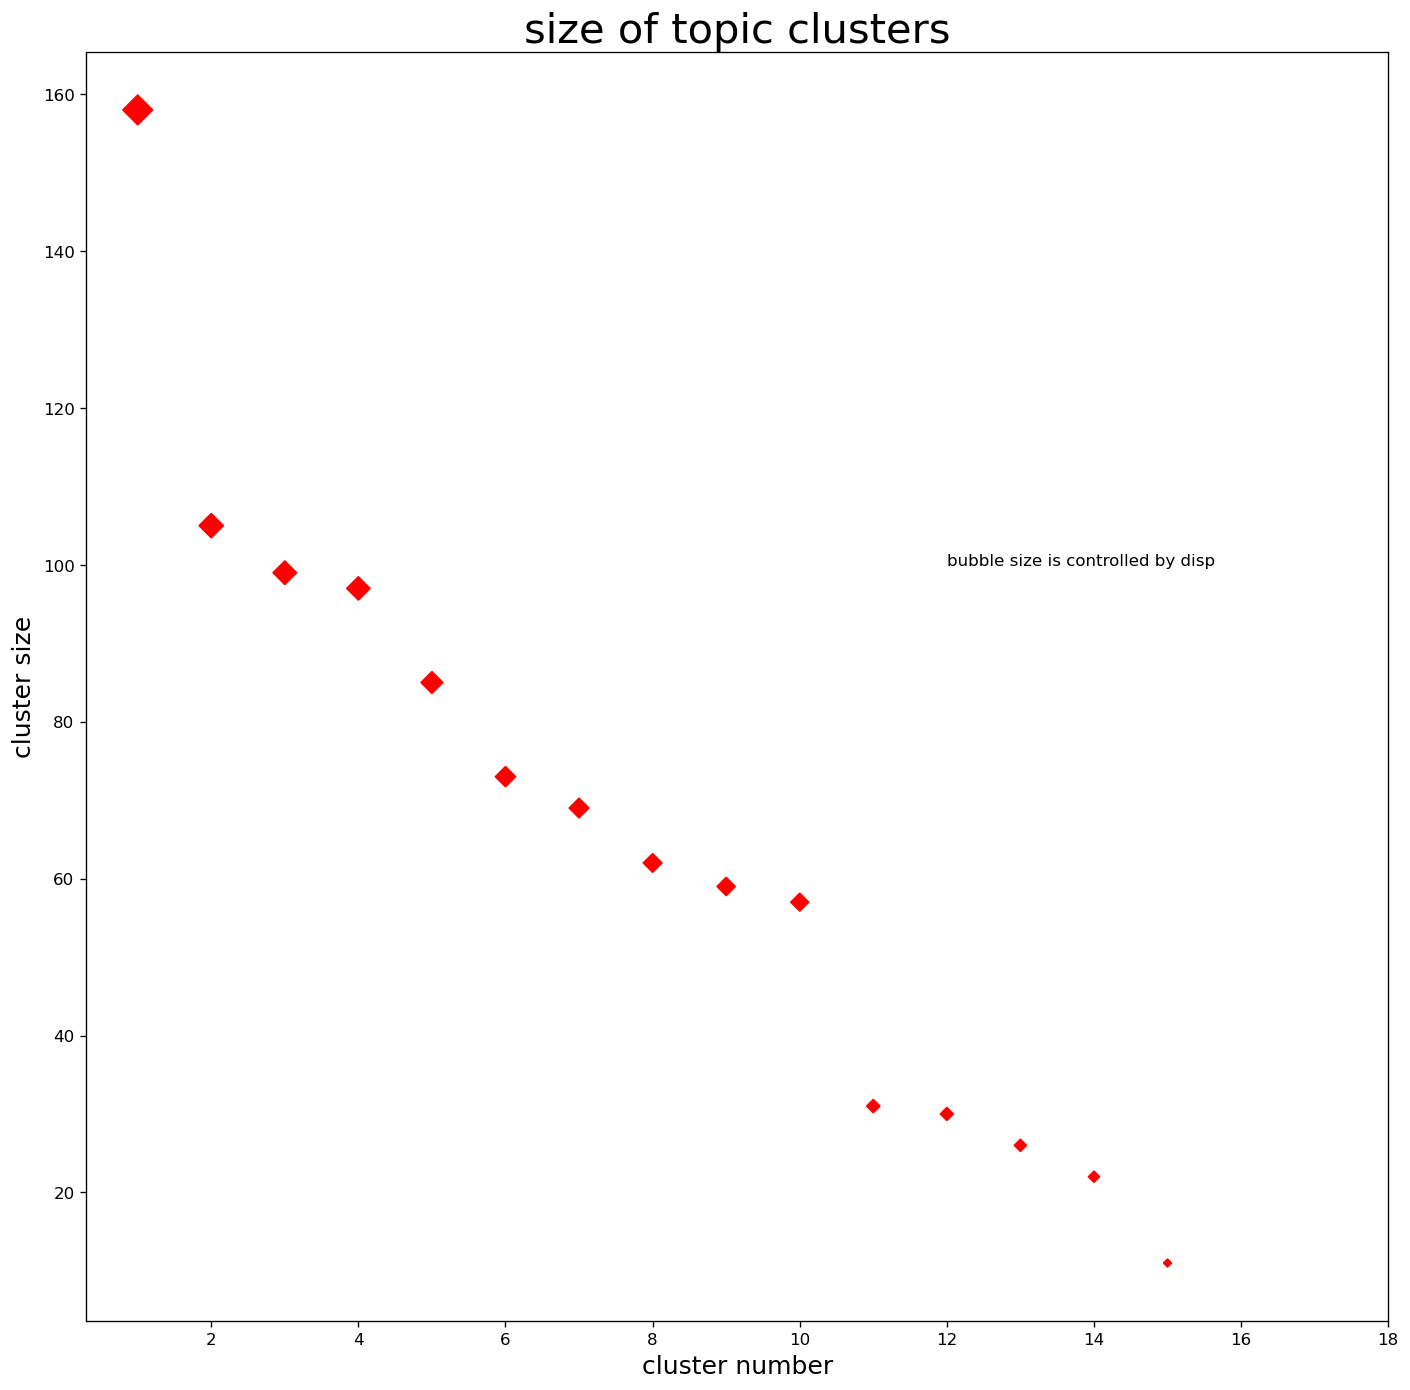

5
Populating the interactive namespace from numpy and matplotlib


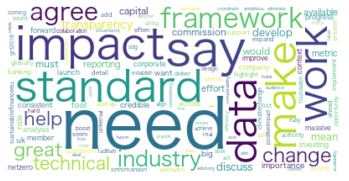

7
Populating the interactive namespace from numpy and matplotlib


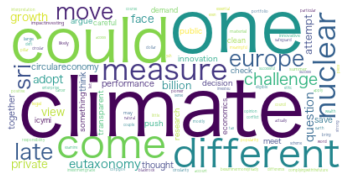

6
Populating the interactive namespace from numpy and matplotlib


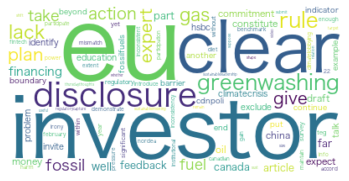

0
Populating the interactive namespace from numpy and matplotlib


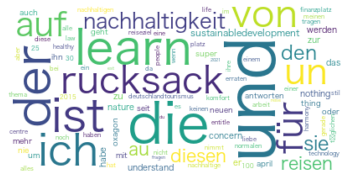

13
Populating the interactive namespace from numpy and matplotlib


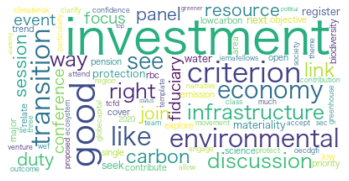

2
Populating the interactive namespace from numpy and matplotlib


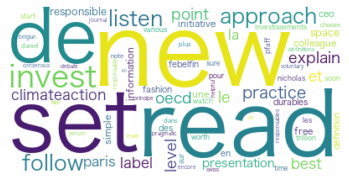

9
Populating the interactive namespace from numpy and matplotlib


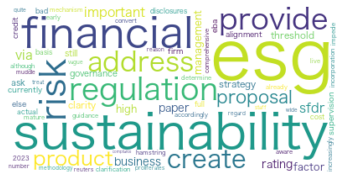

3
Populating the interactive namespace from numpy and matplotlib


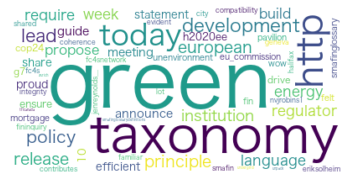

10
Populating the interactive namespace from numpy and matplotlib


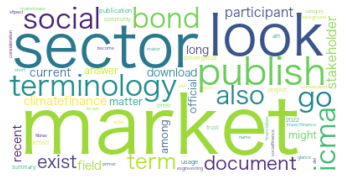

4
Populating the interactive namespace from numpy and matplotlib


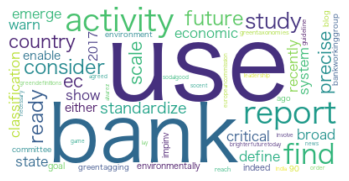

12
Populating the interactive namespace from numpy and matplotlib


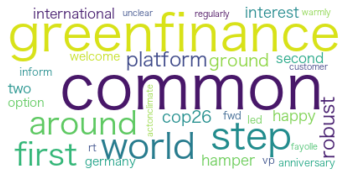

8
Populating the interactive namespace from numpy and matplotlib


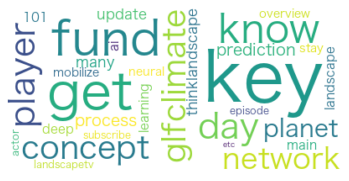

1
Populating the interactive namespace from numpy and matplotlib


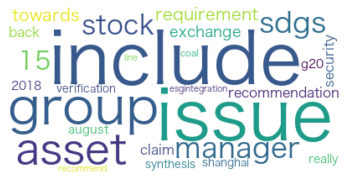

14
Populating the interactive namespace from numpy and matplotlib


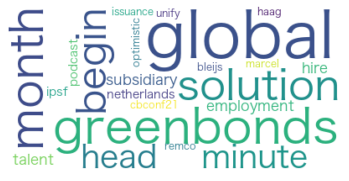

11
Populating the interactive namespace from numpy and matplotlib


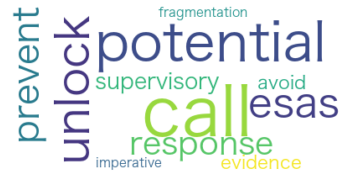

['../data/word_cloud_dict_twitter_all.pkl']

In [5]:
# read the result we obtained in the previous step
g = joblib.load('../data/g_twitter_all.pkl')
stat = joblib.load('../data/stat_twitter_all.pkl')
partition = community_louvain.best_partition(g,random_state=99)
pa = partition.copy()
stat = dict()
for i,j in pa.items():
    if j not in stat.keys():
        stat[j] = 1
    else:
        stat[j] += 1
# draw the cluster size figure
fig,ax = plt.subplots(figsize = (14,14),dpi = 120)
ax.scatter(range(1,len(stat) + 1),sorted(stat.values())[::-1],marker = "D",c = "red",s = sorted(stat.values())[::-1],alpha = 1)
ax.set_xlabel("cluster number",fontsize = 15)
ax.set_xticks([2,4,6,8,10,12,14,16,18])
ax.set_ylabel("cluster size",fontsize = 15)
ax.set_title("size of topic clusters",fontsize = 25)
ax.text(12,100,"bubble size is controlled by disp")
plt.show()

# draw the word cloud from big to small (cluster size)
mytext = dict()
word_cloud_dict = dict()
stat = dict(sorted(stat.items(), key=lambda x: x[1], reverse=True))

for cc in stat.keys():
    print(cc)
    
    if stat[cc]:
        
        for i in pa.keys():
            if pa[i] not in mytext.keys():
                mytext[pa[i]] = ""
            mytext[pa[i]] += x[:,i].T.sum() * (countvec.get_feature_names()[i] + " ")
            
        word_counts = collections.Counter(mytext[cc].split(" "))
        wc = WordCloud(font_path="Hiragino Sans GB.ttc",background_color = "white").generate(mytext[cc])
    
        
        
        wc.generate_from_frequencies(word_counts)
        %pylab inline
        
        plt.imshow(wc, interpolation='bilinear')
        
        plt.axis("off")
        plt.show()
        # Suppose we have the following dictionary:

        sorted_dict = dict(sorted(dict(word_counts).items(), key=lambda item: item[1], reverse=True))
        word_cloud_dict[cc] = sorted_dict

# all the information about each word cluster are stored in word_cloud_dict
joblib.dump(word_cloud_dict,'../data/word_cloud_dict_twitter_all.pkl')
        

In [6]:
# how to read the composition of each word cloud and let the chatgpt to help you impute the topic of each cluster?

# first you need to know the relaionship between the key of word_cloud_dict and the word cloud

# here are the keys of word_cloud_dict

word_cloud_dict.keys()

dict_keys([5, 7, 6, 0, 13, 2, 9, 3, 10, 4, 12, 8, 1, 14, 11])

The sequence of the keys in word_cloud_dict is same as the sequence of word cloud showed in the previous cell.
Like for the key 8, it refers to the first word cloud as follows: ![matrix](../images/exp2.png)

In [7]:
# then the composition of this word cloud is:
word_cloud_dict[5]

{'need': 61,
 'say': 25,
 'impact': 21,
 'standard': 20,
 'make': 18,
 'work': 18,
 'data': 17,
 'framework': 15,
 'agree': 13,
 'industry': 13,
 'change': 11,
 'great': 10,
 'help': 10,
 'technical': 10,
 'transparency': 10,
 'develop': 9,
 'discuss': 9,
 'mean': 9,
 'capital': 8,
 'commission': 8,
 'must': 8,
 'would': 8,
 'available': 7,
 'effort': 7,
 'metric': 7,
 'reporting': 7,
 'big': 6,
 'credible': 6,
 'importance': 6,
 'role': 6,
 'tool': 6,
 'uk': 6,
 'want': 6,
 'across': 5,
 'analysis': 5,
 'company': 5,
 'consistent': 5,
 'context': 5,
 'corporate': 5,
 'forward': 5,
 'improve': 5,
 'investing': 5,
 'launch': 5,
 'massive': 5,
 'member': 5,
 'netzero': 5,
 'progress': 5,
 'add': 4,
 'ahead': 4,
 'banking': 4,
 'climatechange': 4,
 'detail': 4,
 'expand': 4,
 'globally': 4,
 'highlight': 4,
 'implement': 4,
 'list': 4,
 'often': 4,
 'seem': 4,
 'settimanasri': 4,
 'support': 4,
 'sustainablefinanceeu': 4,
 'act': 3,
 'africa': 3,
 'achieve': 3,
 'agenda': 3,
 'align': 3,


You can follow the gudiance in the following example by copying your word cloud composition to Chatgpt to impute the topic of a given word cluster:
![matrix](../images/chatgpt1.png)
![matrix](../images/chatgpt2.png)

## 1.2 Impute the topics of posts with only nouns from Twitter


100%|██████████| 513/513 [01:18<00:00,  6.56it/s]


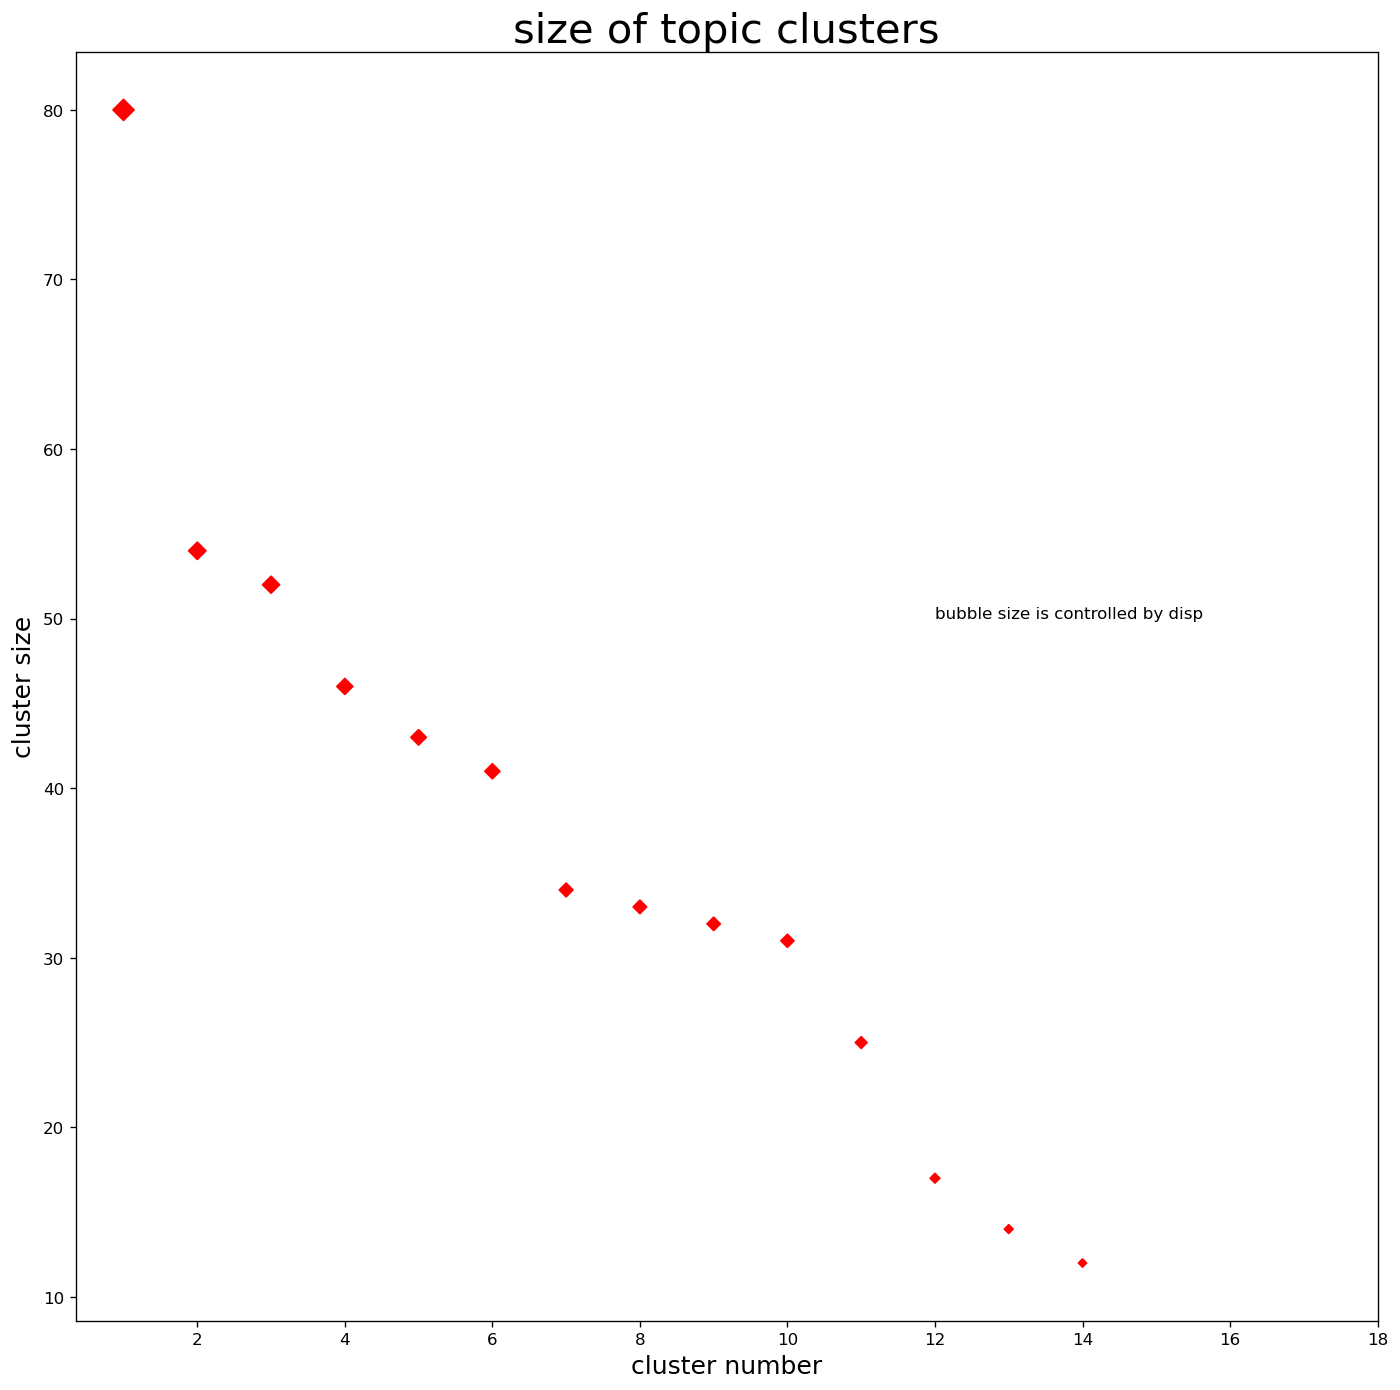

12
Populating the interactive namespace from numpy and matplotlib


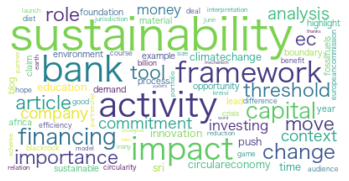

6
Populating the interactive namespace from numpy and matplotlib


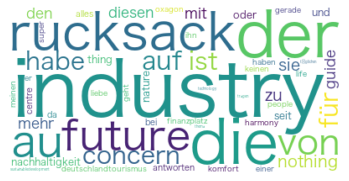

3
Populating the interactive namespace from numpy and matplotlib


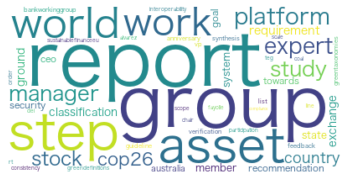

4
Populating the interactive namespace from numpy and matplotlib


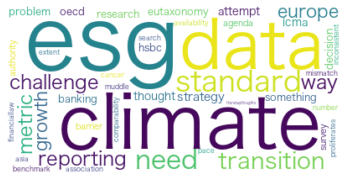

9
Populating the interactive namespace from numpy and matplotlib


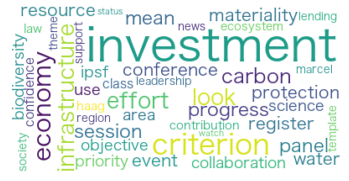

0
Populating the interactive namespace from numpy and matplotlib


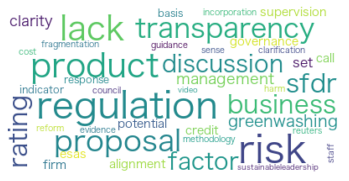

13
Populating the interactive namespace from numpy and matplotlib


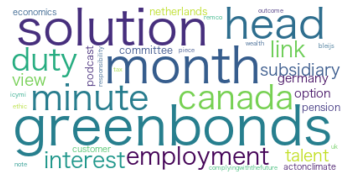

11
Populating the interactive namespace from numpy and matplotlib


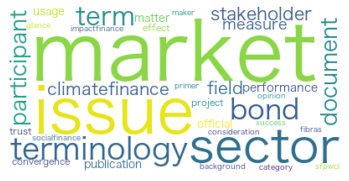

1
Populating the interactive namespace from numpy and matplotlib


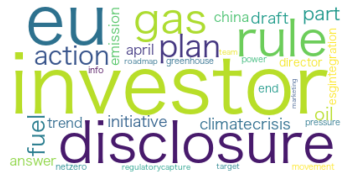

8
Populating the interactive namespace from numpy and matplotlib


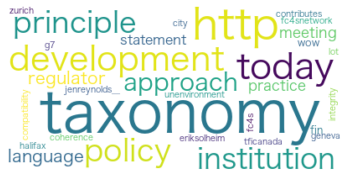

10
Populating the interactive namespace from numpy and matplotlib


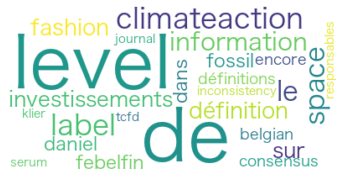

7
Populating the interactive namespace from numpy and matplotlib


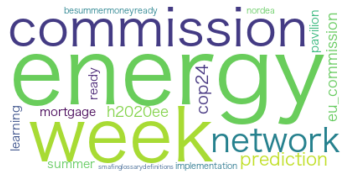

5
Populating the interactive namespace from numpy and matplotlib


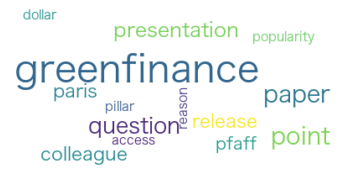

2
Populating the interactive namespace from numpy and matplotlib


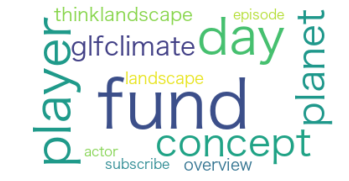

['../data/word_cloud_dict_twitter_noun.pkl']

In [8]:
# read the data
data = pd.read_csv('../data/Twitter.csv')

# forma the type of all the columns we are going to focus on
data['content_all'] = data['content_all'].fillna('[]')
data['content_noun'] = data['content_noun'].fillna('[]')


data['content_all'] = data['content_all'].apply(lambda x:eval(x))
data['content_noun'] = data['content_noun'].apply(lambda x:eval(x))

data['content_all'] = data['content_all'].apply(lambda x: [''] if x == '' else x)
data['content_noun'] = data['content_noun'].apply(lambda x: [''] if x == '' else x)
# for each post, put the title, content and all the comments together for next-step analysis
data['text'] = data.apply(lambda x:' '.join(x['content_noun']),axis = 1)
# we drop the word appears very frequently or just appear one time to aviod the noise from randomly occurring words or high-frequency words
max_df = 0.2
min_df = 2
tf = TfidfVectorizer(max_df=max_df,min_df=min_df)
tf_matrix = tf.fit_transform(data["text"].tolist())
want_word = set(tf.get_feature_names())
data["word"] = data["text"].apply(lambda x: " ".join([i for i in x.split(" ") if i in want_word]))
# here we split each post in to a vector of words
countvec = CountVectorizer()
x = countvec.fit_transform(data.word.tolist())

# then we built the Louvain community network and split the word into non-overlapped cluster
# the intuition here is to put words tends to have simultaneous appearance into the same cluster
g = nx.Graph()
for i in tqdm(range(1,x.shape[1])):
    for j in range(i):
        if x[:,i].T.dot(x[:,j].T.T).sum() != 0:
            g.add_edge(i,j,weight = x[:,i].T.dot(x[:,j].T.T).sum() / (np.sqrt(x[:,i].T.dot(x[:,i].T.T).sum()) * np.sqrt(x[:,j].T.dot(x[:,j].T.T).sum())))
        
partition = community_louvain.best_partition(g,random_state=99)
pa = partition.copy()
stat = dict()
for i,j in pa.items():
    if j not in stat.keys():
        stat[j] = 1
    else:
        stat[j] += 1
# it will take long time for the louvain algorithms to process the information, we suggest you to store the result for each step
joblib.dump(g,'../data/g_twitter_noun.pkl')
joblib.dump(stat,'../data/stat_twitter_noun.pkl')

# read the result we obtained in the previous step
g = joblib.load('../data/g_twitter_noun.pkl')
stat = joblib.load('../data/stat_twitter_noun.pkl')
partition = community_louvain.best_partition(g,random_state=99)
pa = partition.copy()
stat = dict()
for i,j in pa.items():
    if j not in stat.keys():
        stat[j] = 1
    else:
        stat[j] += 1
# draw the cluster size figure
fig,ax = plt.subplots(figsize = (14,14),dpi = 120)
ax.scatter(range(1,len(stat) + 1),sorted(stat.values())[::-1],marker = "D",c = "red",s = sorted(stat.values())[::-1],alpha = 1)
ax.set_xlabel("cluster number",fontsize = 15)
ax.set_xticks([2,4,6,8,10,12,14,16,18])
ax.set_ylabel("cluster size",fontsize = 15)
ax.set_title("size of topic clusters",fontsize = 25)
ax.text(12,50,"bubble size is controlled by disp")
plt.show()

# draw the word cloud from big to small (cluster size)
mytext = dict()
word_cloud_dict = dict()
stat = dict(sorted(stat.items(), key=lambda x: x[1], reverse=True))

for cc in stat.keys():
    print(cc)
    
    if stat[cc]:
        
        for i in pa.keys():
            if pa[i] not in mytext.keys():
                mytext[pa[i]] = ""
            mytext[pa[i]] += x[:,i].T.sum() * (countvec.get_feature_names()[i] + " ")
            
        word_counts = collections.Counter(mytext[cc].split(" "))
        wc = WordCloud(font_path="Hiragino Sans GB.ttc",background_color = "white").generate(mytext[cc])
    
        
        
        wc.generate_from_frequencies(word_counts)
        %pylab inline
        
        plt.imshow(wc, interpolation='bilinear')
        
        plt.axis("off")
        plt.show()
        # Suppose we have the following dictionary:

        sorted_dict = dict(sorted(dict(word_counts).items(), key=lambda item: item[1], reverse=True))
        word_cloud_dict[cc] = sorted_dict

# all the information about each word cluster are stored in word_cloud_dict
joblib.dump(word_cloud_dict,'../data/word_cloud_dict_twitter_noun.pkl')
        